
### Exploring the Seattle AirBnb Dataset
**1. Business Understanding**

    This notebook follows the CRISP-DM process to analyze the Seattle AirBnb Open Data on Kaggle.

    To start, let’s look at the context of the Dataset. As per the Description in the Data section of Kaggle:

 Context

    Since 2008, guests and hosts have used Airbnb to travel in a more unique, personalized way. As part of the
    Airbnb Inside initiative, this dataset describes the listing activity of homestays in Seattle, WA.

    These are the 3 guiding questions for our analysis:

    What are the distribution of listing prices by neighborhoods?
    How varied are the expensive neighborhoods in terms of property type?
    How well can we predict listing price?

**2. Data Understanding**

    As per the Description in the Data section of Kaggle:

    Content

    The following Airbnb activity is included in this Seattle dataset: Listings, including full descriptions
    and average review score Reviews, including unique id for each reviewer and detailed comments * Calendar,
    including listing id and the price and availability for that day

For the purposes of this analysis, the focus will be limited to the Listings data exclusively since that is all that is needed to address the three guiding questions.

2.1 Initial Data Assessment

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import plotly.offline as pyo
import plotly.graph_objs as go

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [4]:
listings = pd.read_csv('data/listings.csv')
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [5]:
print('listings dimensions:',listings.shape)

listings dimensions: (3818, 92)


In [6]:
listings.dtypes

id                                    int64
listing_url                          object
scrape_id                             int64
last_scraped                         object
name                                 object
                                     ...   
cancellation_policy                  object
require_guest_profile_picture        object
require_guest_phone_verification     object
calculated_host_listings_count        int64
reviews_per_month                   float64
Length: 92, dtype: object

2.2 Unique Values

Most columns have a limited of unique values but there appear to be a few columns that have a unique value for almost every row. These are probably the id and/or url fields

array([[<AxesSubplot:title={'center':'Unique Value Count'}>]],
      dtype=object)

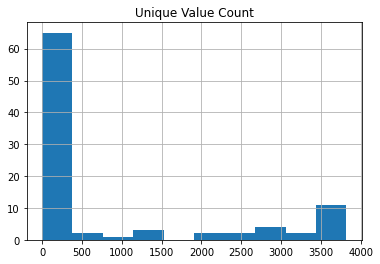

In [7]:
pd.DataFrame((listings.T.apply(lambda x: x.nunique(), axis=1)), columns=['Unique Value Count']).hist()

2.3 Null Values

Null values can and will lead to issues for analysis later on. Below are columns sorted by null value count.

In [8]:
pd.DataFrame(np.sum(listings.isnull()), columns=['null_count']).sort_values(by='null_count', ascending=False)

,null_count
license,3818
square_feet,3721
monthly_price,2301
security_deposit,1952
weekly_price,1809
...,...
room_type,0
accommodates,0
bed_type,0
amenities,0


In [47]:
# view columns with the most null values by %
pd.DataFrame(((np.sum(listings.isnull()) / listings.shape[0]) * 100), columns=['null%']).sort_values(by='null%', ascending=False)

,null%
license,100.000000
square_feet,97.459403
monthly_price,60.267156
security_deposit,51.126244
weekly_price,47.380828
...,...
room_type,0.000000
accommodates,0.000000
bed_type,0.000000
amenities,0.000000


There are a few neighbourhood variables. Below are the neighbourhood variables by null count.

In [12]:
# filter null count to only show neighbourhood variables

np.sum(listings[[i for i in listings.columns.tolist() if 'neighbourhood' in i]].isnull())

host_neighbourhood              300
neighbourhood                   416
neighbourhood_cleansed            0
neighbourhood_group_cleansed      0
dtype: int64

2.4 Pairplots

Since our analysis is largely revoling around price and its relation to other variables, we can utilize seaborn's pairplot function.

The first pairplot is price along with host variables. The second pairplot is price along with property details.

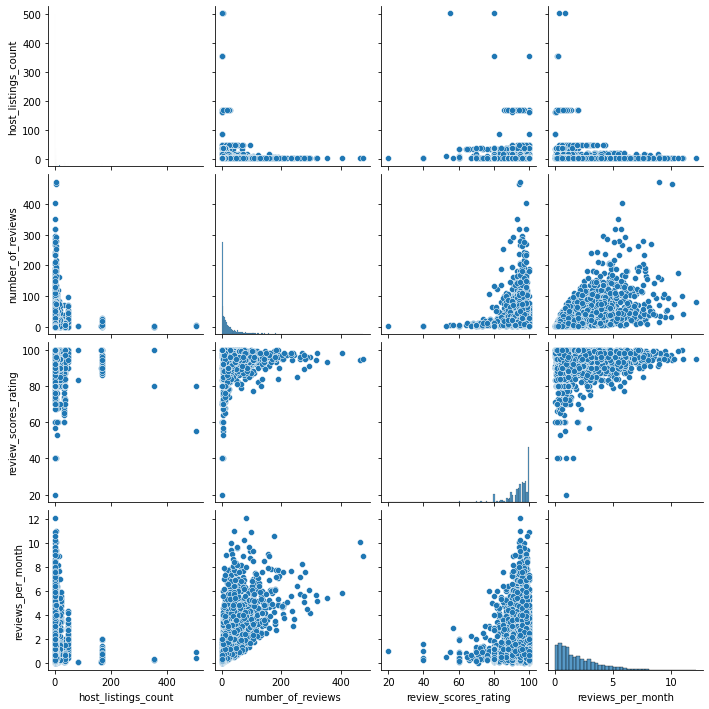

In [13]:
# Pairplot of review variables
review_pairplot_df = listings[[  "price", "host_is_superhost","host_listings_count", "number_of_reviews", "review_scores_rating", "cancellation_policy", 
               "reviews_per_month"]]

sns.pairplot(review_pairplot_df);

If a reviewer has a lot of reviews per month then the price is tending to be lower. The lowest scored hosts are also on the lower end of listing prices.

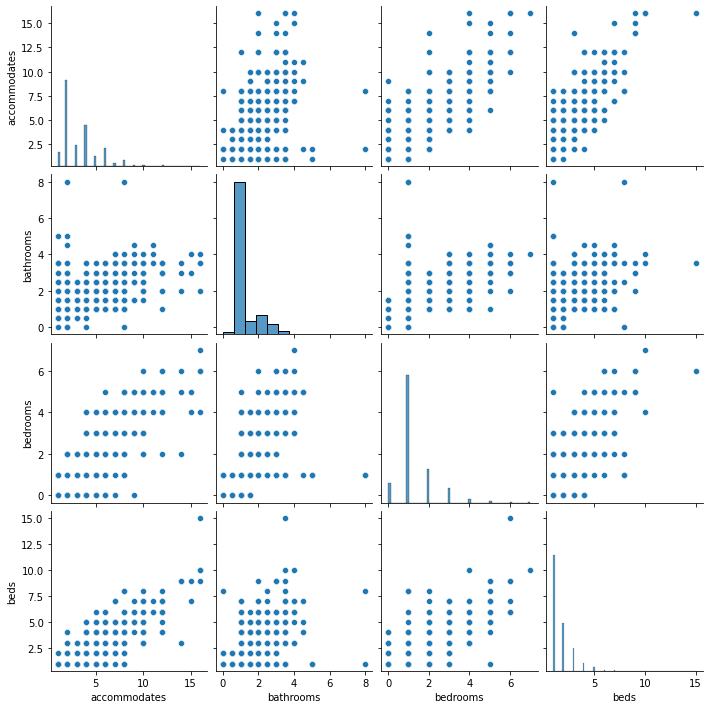

In [14]:
property_pairplot_df =  listings[[ "price", "accommodates", "bathrooms", "bedrooms", "beds"]]

sns.pairplot(property_pairplot_df);

There appears to be some collinearity between the 'accomodates' variable and the other property details variables.


2.5 Formatting Price column

The 'price' variable is central to all three questions, so let's take a look at it to see if any cleaning is required


In [24]:
listings[['price']].head()

,price
0,$85.00
1,$150.00
2,$975.00
3,$100.00
4,$450.00


The price column has unwanted characters that would cause data processing issues later on, so these characters will be removed and datatype will be converted to float

In [25]:
listings['price'] = listings['price'].str.replace("[$, ]", "").astype("float64")
print(listings.price.describe())

count    3818.000000
mean      127.976166
std        90.250022
min        20.000000
25%        75.000000
50%       100.000000
75%       150.000000
max      1000.000000
Name: price, dtype: float64


C:\Users\Gill\AppData\Local\Temp/ipykernel_15060/3610939297.py:1: FutureWarning:

The default value of regex will change from True to False in a future version.





Now that the price column has been formatted properly, the first two questions can be addressed.


**What are the distribution of listing prices by neighborhoods?**

In [26]:
neighbourhood_list = listings['neighbourhood_cleansed'].unique().tolist()
hist_data = []

for neighbourhood in neighbourhood_list:
    trace = go.Histogram(x = listings.loc[df['neighbourhood_cleansed'] == neighbourhood].price.tolist(), opacity=0.75, name = neighbourhood)
    hist_data.append(trace)

hist_layout = go.Layout(barmode='stack', xaxis = dict(title='Listing Price'), yaxis = dict(title='Count'))
hist_fig = go.Figure(data=hist_data, layout=hist_layout)

hist_fig.show()



This histogram shows us that there is a long tail for listing prices but that a majority are under $200. The visualization doesn't help aid in our intution of how listings are distributed by neighborhood however.

Before being able to address question two, a dataframe of listings grouped by price will be created with mean and standard deviation calculated.


In [27]:
listings['price']

0        85.0
1       150.0
2       975.0
3       100.0
4       450.0
        ...  
3813    359.0
3814     79.0
3815     93.0
3816     99.0
3817     87.0
Name: price, Length: 3818, dtype: float64

In [28]:


neighborhood_mean_df = pd.DataFrame(listings.groupby('neighbourhood_cleansed').mean()['price'].sort_values(ascending=False))
neighborhood_mean_df = neighborhood_mean_df.rename(columns = {'price': 'mean_price'})

neighborhood_std_df = pd.DataFrame(listings.groupby('neighbourhood_cleansed').std()['price'].sort_values(ascending=False))
neighborhood_std_df = neighborhood_std_df.rename(columns = {'price': 'std_price'})

neighborhood_df = neighborhood_mean_df.merge(neighborhood_std_df, on='neighbourhood_cleansed')

top_10 = neighborhood_df.index[:10].tolist() # the subset of neighborhoods we'll analyze for question two

neighborhood_df.head(10)



,mean_price,std_price
neighbourhood_cleansed,,
Southeast Magnolia,231.705882,225.117682
Portage Bay,227.857143,197.523458
Westlake,194.470588,173.057475
West Queen Anne,187.769231,170.476425
Montlake,182.789474,171.700508
Briarcliff,176.571429,96.767536
Sunset Hill,176.055556,149.680630
Industrial District,173.333333,104.769588
Alki,171.619048,97.471685




The Southeast Magnolia and Portage Bay are the most expensive neighborhoods with the average listing exceeding $200.

The standard deviations are also high for these neighborhoods. Numeric text though is limited in helping build an intuition around the data, so I visualized the distribution of the data with a box plot for each neighborhood.


In [ ]:
box_data = []

for neighbourhood in top_10:
    trace = go.Box(x = listings.loc[listings['neighbourhood_cleansed'] == neighbourhood].price.tolist(), name = neighbourhood)
    box_data.append(trace)

box_layout = go.Layout(xaxis = dict(title='Listing Price'))
box_fig = go.Figure(data=box_data, layout=box_layout)

box_fig.show()



This visualization helps to show outliers in the data and differences in neighborhoods in terms of median listing price. The five most expensive neighborhoods all ahve outliers greater than $500.

Property type will be looked at next to see if that can provide insight into variation within neighbourhoods.



How does the property type impact listing price on a neighborhood basis?

The dataframe is grouped by neighbourhood and property type in order to view the prevalance of different property types in the most expensive neighborhoods


In [30]:
stacked_bar_df = pd.DataFrame(listings.loc[df['neighbourhood_cleansed'].isin(top_10) ].groupby(['neighbourhood_cleansed', 'property_type']).count()['id']).reset_index()
property_type_list = stacked_bar_df.property_type.unique().tolist()

stacked_bar_data = []

for property_type in property_type_list:
        stacked_bar_trace = go.Bar(name = property_type, x= top_10, y =stacked_bar_df[stacked_bar_df['property_type']== property_type]['id'].tolist())
        stacked_bar_data.append(stacked_bar_trace)
        
stacked_bar_layout = go.Layout(title = 'Property Type Count in Top 10 Most Expensive Neighborhoods',
                   barmode = 'stack',
                  yaxis = dict(title='Count'))    
    
stacked_bar_fig = go.Figure(data=stacked_bar_data, layout=stacked_bar_layout)

stacked_bar_fig.show()



Judging by the stacked bar chart above, the ‘House’ and ‘Apartment’ property types are the majority of listings and most representative of whats available on the market for these neighborhoods.

My initial intuition was that Houses would be more expensive than Apartments on average. This turned out to be the case as the heatmap below illustrates.


In [31]:


# create a heat map showing the mean prices for the two most common property types
property_types = ['House', 'Apartment'] 

# transform data to group it properly to for the heatmap visualization using plotly
heatmap_filtered_df = pd.DataFrame(listings.loc[listings['neighbourhood_cleansed'].isin(top_10) & listings['property_type'].isin(property_types)].groupby(['neighbourhood_cleansed', 'property_type']).mean()['price']).reset_index()

heatmap_group = heatmap_filtered_df.groupby('neighbourhood_cleansed')
heatmap_df = pd.DataFrame(heatmap_group.apply(lambda x: x['price'].unique())) # creates a row for each neighborhood with an array of mean prices by property type

heatmap_df.columns = ['price']

heatmap_price= heatmap_df.price.tolist()

heatmap_index = heatmap_df.index.tolist()

heatmap_trace = go.Heatmap(
    z = heatmap_price,
    x = ['Apartment', 'House'],
    y = heatmap_index
)
heatmap_data = [heatmap_trace]


heatmap_layout = dict(title = 'Comparing Mean Listing Price for Neighborhood by Property Type',
              xaxis= dict(automargin = True),
              yaxis = dict(automargin = True)           
             )
heatmap_fig = go.Figure(data=heatmap_trace, layout = heatmap_layout)


heatmap_fig.show()





For every neighbourhood above, the mean house price is higher than the mean apartment price. The one exception is the Industrial District, which only have null values for house listings.

The disparity is most striking in the most expensive neighborhoods, Southeast Magnolia and Portage Bay. This was to be expected though given the relatively larger standard deviation compared to the other neighborhoods.



**3. Data Preparation**

Different data preparation has already been done to primarily address the first two questions through data visualization.

The following is remaining data preparation to format our data for modeling.

Missing values will need to be addressed for numeric variables and dummy columns need to be created to have categorical variables in a useable format for modeling later.

Mean imputation was used to not distort the observed mean. Incorporating outliers isn't necessarily an issue so imputing the mean was chosen over imputing the median.

Categorical variables will be converted using dummy encoding to create n-1 variables.


In [32]:
def clean_data(df):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    Perform to obtain the correct X and y objects
    This function cleans df using the following steps to produce X and y:
    1. Select the numeric variables in the dataset
    2. Imputes the mean to fill null values for numeric variables
    3. Select the categorical variables
    4. Creates dummy columns for the categorical variables
    5. Create X as all the columns that are not the Price column
    6. Create y as the Price column

    '''
  
    num_vars= df.select_dtypes(include=['int','float']).copy().columns

   
    for var in num_vars:
        df[var].fillna((df[var].mean()), inplace=True)

   
    cat_vars = df.select_dtypes(include=['object']).copy().columns

   
    for var in cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
   
    X = df.drop(columns=['price'], axis=1)
    y = df['price']
    
    return X, y


**4. Modeling**

I have chosen a multiple linear regression model for predicting the listing price based upon other independent variables.

The independent variables were chosen based on the criteria of being logically plausible of having a causal impact with the listing price, having relatively few missing values (if any) and a manageable amount of unique values (if a categorical variable).

The clean_data function is used to split the data into the dependent and independent variables.


In [33]:
filtered_df = listings[[ "host_is_superhost","host_listings_count", "neighbourhood_cleansed", "property_type","room_type", "accommodates", "bathrooms", "bedrooms", 
               "beds", "price", "number_of_reviews", "review_scores_rating", "cancellation_policy", 
               "reviews_per_month"]]

X, y = clean_data(filtered_df)

C:\Users\Gill\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [40]:
#sklearn's train_test_split is used split X, y into random train and test subsets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

In [35]:
lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit

C:\Users\Gill\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_base.py:141: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)





LinearRegression(normalize=True)


**5. Results and Evaluation**

5.1 R2 Score and RMSE

The r-squared score and root-mean-square error (RMSE) were used to score the model.

The r-squared score measures for relative goodness-of-fit.

RMSE is an absolute measure of fit. It's useful since it is measured in the same units as the dependent variable. It is a simple loss function that we seek to minimize (without overfitting).

In [37]:
#Predict and score the model
y_train_preds = lm_model.predict(X_train)
print("The r-squared score for your model on the training data was {} on {} values. The RMSE was {}".format(r2_score(y_train, y_train_preds), len(y_train), mean_squared_error(y_train, y_train_preds)))
y_test_preds = lm_model.predict(X_test) 
print("The r-squared score for your model on the test data was {} on {} values.  The RMSE was {}".format(r2_score(y_test, y_test_preds), len(y_test), mean_squared_error(y_test, y_test_preds)))

The r-squared score for your model on the training data was 0.5926903081943571 on 2672 values. The RMSE was 3242.596553930906
The r-squared score for your model on the test data was 0.5975240944346538 on 1146 values.  The RMSE was 3446.6221734160763



The model ended up doing ever so slightly better on the test data than the training data in terms of the r-squared score. This could be due to outliers being more represented in the training data set.

Other options for future analysis to avoid overfitting or underfitting could be explored such as cross-validation.


**5.2 Scatter plot visualizing linear model with Predicted vs Actual values**

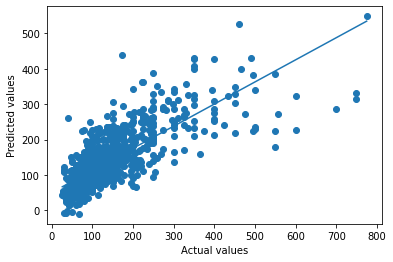

In [38]:
plt.scatter(y_test, y_test_preds)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_test_preds, 1))(np.unique(y_test)))


The above chart indicates that the model does less well at predicting listings at higher actual values.


**5.3 Residual Plot of Training data vs Test data**

A Kaggle user had an engaging visualization in their notebook displaying a residual plot,so I have replicated it here for viewing.


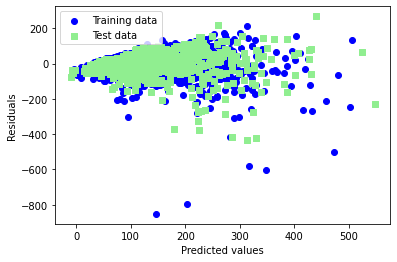

In [39]:
plt.scatter(y_train_preds,  y_train_preds - y_train,
            c='blue', marker='o', label='Training data')
plt.scatter(y_test_preds,  y_test_preds - y_test,
            c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.show()


The plot illustrates well how the training data has a bias to predict a listing price less than its actual value. There are 5 predicted values in the training data that had -400 to -800 residuals.
### Conclusion

The main takeaways from this analysis have been the following:

    Listings roughly follow a normal distribution with a long tail of outlier expensive properties.

    Out of the two most prevlant property types, Houses are on average more expensive than apartments.

    More work can be done to predict listing price. Other variables such as whether host_has_thumbnail could be incorporated or additional data preperation could be done to engineer unique features with more predictive power.

Hope you have enjoyed this digital walk through the neighborhoods of Seattle Airbnb dataset!
